### Import necessary libraries

In [61]:
import sys
import torch

modelpath='./newmodels/'
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
import xarray as xr
import cartopy.crs as ccrs
from scipy.signal import convolve2d
from scipy import ndimage
import pickle

import types


from scipy.interpolate import interpn
from scipy.interpolate import interp1d





Running on the CPU


In [45]:
import joblib
with open('rayleigh_NN_old.pk', 'rb') as f:
    model = pickle.load(f)  # Load with original pandas

joblib.dump(model, 'rayleigh_NN_new.joblib')
# with open('rayleigh_NN_new.pk', 'wb') as f:
#     pickle.dump(model, f, protocol=4)

['rayleigh_NN_new.joblib']

### Neural netwrok model class used during training

In [62]:
class Net3L(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1,n_hidden2, n_hidden3, n_output):
        super(Net3L, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)   # hidden layer
        self.hidden3 = torch.nn.Linear(n_hidden2, n_hidden3)
        self.predict = torch.nn.Linear(n_hidden3, n_output)   # output layer
    def forward(self, x):
        x = torch.nn.LeakyReLU()(self.hidden1(x))     # activation function for hidden layer
        x = torch.nn.LeakyReLU()(self.hidden2(x))
        x = torch.nn.LeakyReLU()(self.hidden3(x))
        x = self.predict(x)
        return x

fn = types.SimpleNamespace(Net3L=Net3L)

def normalize(x,xmin1,xmax1,xmean1, xstd1, option=1):
    if(option==1):
        x=(x-xmin1)/(xmax1-xmin1)
    elif(option==4):
        x=x       
    return x

def inv_normalize(x, xmin1, xmax1, xmean1, xstd1, option=1):
    if(option==1):
        x=x*(xmax1-xmin1)+xmin1

    elif(option==4):
        x=x
    return x
ftool = types.SimpleNamespace(
    normalize=normalize,
    inv_normalize=inv_normalize
)

class nn_model():
    def __init__(self, info, nv, act,
                 learning_rate, batch_size, epochs,
                 nn_state_dict, train1, test_loss1, test_loss2):
        
        self.info = info
        self.nv = nv
        self.activation = act
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs

        self.test_loss1 = test_loss1
        self.test_loss2 = test_loss2

        self.xlabelv = train1.xv_df.keys()
        self.ylabelv = train1.yv_df.keys()

        self.glintmask = train1.glintmask
        self.name = train1.name
        self.xv_normalize_option = train1.xv_normalize_option
        self.yv_normalize_option = train1.yv_normalize_option

        self.xmin = train1.xmin
        self.xmax = train1.xmax
        self.ymin = train1.ymin
        self.ymax = train1.ymax

        self.xmean = train1.xmean
        self.xstd = train1.xstd
        self.ymean = train1.ymean
        self.ystd = train1.ystd

        nx = len(self.xlabelv)
        ny = len(self.ylabelv)

        self.nn = fn.Net3L(nx, nv[0], nv[1], nv[2], ny)
        self.nn.load_state_dict(nn_state_dict())

        self.xv_range_df = train1.xv_range_df
        self.angle_labelv = ['zen', 'az', 'solzen']
        if self.angle_labelv[0] in self.xv_range_df.keys():
            self.angle_range_df = self.xv_range_df[self.angle_labelv]
            self.coeff_range_df = self.xv_range_df.drop(columns=self.angle_labelv)
        else:
            print("No angles in training data")

    def forward(self, device, xpv):
        xpv1 = ftool.normalize(xpv, self.xmin.values, self.xmax.values,
                               self.xmean.values, self.xstd.values, self.xv_normalize_option)
        output = self.nn(torch.Tensor(xpv1).to(device)).cpu().data.numpy()
        return ftool.inv_normalize(output,
                                   self.ymin.values, self.ymax.values,
                                   self.ymean.values, self.ystd.values, self.yv_normalize_option)

sys.modules['fastmapol'] = types.ModuleType('fastmapol')
sys.modules['fastmapol.train'] = types.ModuleType('train')
sys.modules['fastmapol.net'] = types.ModuleType('net')
sys.modules['fastmapol.tool'] = types.ModuleType('tool')

# Step 3: Inject local classes/functions into the modules created here
sys.modules['fastmapol.train'].nn_model = nn_model
sys.modules['fastmapol.net'].Net3L = Net3L
sys.modules['fastmapol.tool'].normalize = normalize
sys.modules['fastmapol.tool'].inv_normalize = inv_normalize
#sys.modules['fastmapol.train'].nn_model = nn_model

### Functions to load L1C and ancilliary data

In [63]:

def anc_data_reader(file):

    ds1 = xr.open_dataset(file)

    lat = ds1['latitude'].values
    lon = ds1['longitude'].values
    o3 = ds1['TO3'].values/345.23947 #divided by standard US atm, as in training of FastMAPOL/component's neural network
    rh = ds1['RH'].values[0,:,:]
    ps = ds1['SLP'].values/100
    wf=ds1['waterfraction'].values
    wf = np.where(wf == 1, wf, np.nan)
    kernel = np.ones((3, 3), dtype=int)

   # Convert NaNs to 0 for convolution, then apply filter
    wf_bin = np.where(np.isnan(wf), 0, 1)  # Convert NaNs to 0, keep 1s
    conv_result = convolve2d(wf_bin, kernel, mode='same', boundary='fill', fillvalue=0) #This is done to remove land pixels

# If all 9 pixels in the 3x3 window are 1, set to 1; otherwise, NaN
    wffil = np.where((conv_result == 9) & (wf == 1), 1, np.nan)
    
    return fill_nearest(o3), fill_nearest(ps)

def l1c_data_reader(file):
    ds1 = xr.open_dataset(file, group='geolocation_data')
    ds1s = xr.open_dataset(file, group='sensor_views_bands')
    ds1o = xr.open_dataset(file, group='observation_data',mask_and_scale=True)

    
    lat = ds1['latitude'].values
    lon = ds1['longitude'].values
    
    wavelengths = ds1s['intensity_wavelength'].values[0]
    intensity = ds1o['i'].values[:,:,1,:]
    f0 = ds1s['intensity_f0'].values[0]
    
    solzen = ds1['solar_zenith_angle'].values[:,:,1]
    solzen1=np.reshape(solzen,(*solzen.shape,1))* np.ones((1, 1, intensity.shape[2]))
    ref=np.pi*intensity/(np.cos(solzen1*np.pi/180.0)*f0)
    
    zen = ds1['sensor_zenith_angle'].values
    az0 = ds1['sensor_azimuth_angle'].values
    solaz = ds1['solar_azimuth_angle'].values    
    az=set_az(set_az0(az0, solaz, flag_bin2sun=True))

    
    return lat,lon,solzen,ref[:,:,20:239],wavelengths[20:239],zen,az

def fill_nearest(arr):
    # This function is used to fill the ancilliary data in missing pixels from neighboring pixels.
    nan_mask = np.isnan(arr)

    # Replace NaNs with large negative or positive numbers temporarily (for processing)
    # Use an arbitrary large number that won't conflict with real values
    arr_filled = np.copy(arr)
    arr_filled[nan_mask] = 0  # Set NaNs to zero or any placeholder

    # Perform nearest neighbor interpolation to fill NaNs
    nearest_idx = ndimage.distance_transform_edt(nan_mask, return_distances=False, return_indices=True)
    filled_arr = arr_filled[tuple(nearest_idx)]

    return filled_arr


def set_az0(az, solaz, flag_bin2sun=True):
    """Compute azimuth angle for the ray
    Note:
    bin2sun, used in pace l1c convention
    az0: in the range of [0,360]
    az: in the range of [0,180]
    """
    #
    if(flag_bin2sun):
        #bin2sun, used in pace l1c convention
        tmp1=az-solaz+180.0
    else:
        #sun2bin direction
        tmp1=az-solaz

    tmp1[tmp1>360]=tmp1[tmp1>360]-360
    tmp1[tmp1<0]=-tmp1[tmp1<0]
    return tmp1

def set_az(az0):
    """
    compute the az which will be used in NN
    ensure that phi is between 0-180
    """
    az = az0.copy()
    az[az<0.0] += 360.0
    az[az>180.0] = 360.0 - az[az>180.0]
    return az
    


def rgb_image(ax,ref,wavelengths):
    def find_closest(wavelength_array, target_nm):
        return np.argmin(np.abs(wavelength_array - target_nm))
    
    idx_blue = find_closest(wavelengths, 440)
    idx_green = find_closest(wavelengths, 550)
    idx_red = find_closest(wavelengths, 670)    

    R = ref[:, :,idx_red]
    G = ref[:, :,idx_green]
    B = ref[ :, :,idx_blue]
            
    def color_scaling(R, G, B):
        # Stack
        rgb = np.stack([R, G, B], axis=-1)
        # Normalize

        rgb = np.clip(rgb / 0.4, 0, 1)  
        # Gamma correction
        rgb = rgb** (1 /2.2)#gamma  scaling
        return rgb
       
    rgb = color_scaling(R, G, B) 

    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m', linewidth=0.5)
    ax.gridlines(draw_labels=True, color='gray', linewidth=0.3)

    ax.pcolormesh(lon, lat, rgb,
              transform=ccrs.PlateCarree(), shading='auto')

### Load Neural Network model developed for Atmospheric correction in FastMAPOL/component joint retreval algorithm

In [64]:
def load_nn(device,modelpath):
    nn_refas_path=modelpath+'/recoas206_d3-101_n10000refas_x14y13_s111_n19148_r500_glintmask0_set5x600x300x150x13_bs1000_nx9574000_v4171_best.pk'
    nn=pickle.load(open(nn_refas_path,'rb'))
    nn.nn.to(device)    
    return nn

### Neural network's training hyperparameters and input parameters

In [65]:
nn=load_nn(device,modelpath)

print(nn.activation)
print(nn.name)
print(nn.nv)
print(nn.xlabelv)
print(nn.xv_normalize_option)
print(nn.yv_normalize_option)



LeakyReLU
refas
[600, 300, 150]
Index(['zen', 'az', 'solzen', 'wndspd', 'aod', 'alh', 'fmf', 'ss', 'fnai',
       'bc', 'brc', 'rh', 'o3', 'ps'],
      dtype='object')
1
4


### Functions to create input vector for Neural network 

In [24]:
## Set aerosol parameters to very low value. The parameters include AOD, ALH, FmF, SS, FNAI, BC, BrC and RH

def nn_input_vector(zen, az, solzen, o3, ps):
    H, W = ps.shape
    inputs = np.zeros((H, W, 14), dtype=np.float32)
    inputs[..., 0] = zen
    inputs[..., 1] = az
    inputs[..., 2] = solzen
    inputs[..., 3:12] = 0.001  # Fixed aerosol-related inputs
    inputs[..., 12] = o3
    inputs[..., 13] = ps
    return inputs




### Functions to calculate Rayleigh reflectance at NN's wavelengths and interpolate that to finer resolutions

In [56]:
def rayleigh_ref(device, inputs, nn):    
    refv=nn.forward(device, inputs)
    return refv

def rayleigh_ref_interp(refl_nn, wl_fine):
    """
    refl_nn: (H, W, 13) — NN-predicted Rayleigh reflectance at coarse wavelengths
    wl_fine: target wavelengths to interpolate to
    returns: (H, W, wl_fine.shape) — interpolated Rayleigh reflectance
    """
    H, W, _ = refl_nn.shape
    wl_nn = np.array([385, 400, 410, 440, 470, 490, 510, 530, 550, 620, 670, 740, 870], dtype=np.float32)
    wl_fine = wl_fine

    # shape_nn = (wl_nn / wl_nn.min()) ** -4
    # shape_fine = (wl_fine / wl_nn.min()) ** -4

    # shape_nn = shape_nn.reshape(1, 1, -1)
    # shape_fine = shape_fine.reshape(1, 1, -1)

    # numerator = np.sum(refl_nn * shape_nn, axis=2)
    # denominator = np.sum(shape_nn ** 2)
    # scale = numerator / denominator

    # return scale[:, :, np.newaxis] * shape_fine

    # For each fine wavelength, find index of nearest NN wavelength
    idx_nearest = np.abs(wl_nn[None, :] - wl_fine[:, None]).argmin(axis=1) 
    wl_nearest = wl_nn[idx_nearest]
    
    # Compute scale factor c = I * λ⁴ at nearest wavelength
    refl_nearest = refl_nn[:, :, idx_nearest]  # (H, W, 286)
    c = refl_nearest * (wl_nearest[np.newaxis, np.newaxis, :] ** 4)  # (H, W, 286)

    # Rayleigh reflectance at fine wavelengths
    rayleigh_interp = c / (wl_fine[np.newaxis, np.newaxis, :] ** 4)

    return rayleigh_interp

### Rayleigh correction for OCI/SPEXone/HARP2 images

### Load L1C and ancilliary data

In [55]:
## For OCI
fileanc='PACE.20240720T140430.L1C.ANC.5km.nc'
file='PACE_OCI.20240720T140430.L1C.V3.5km.nc'

##For SPEXonne
# fileanc='PACE.20240720T140430.L1C.ANC.5km.spex_width.nc'
# file='PACE_SPEXONE.20240720T140430.L1C.V2.5km.nc'

lat,lon,solzen,ref,wavelengths,zen,az=l1c_data_reader(file)
o3,ps=anc_data_reader(fileanc)


### Calculate Rayleigh reflectance at 13 NN wavelengths and interpolate them according to instrument's wavelength

In [57]:
nn = load_nn(device,modelpath)
inputp=nn_input_vector(zen[:,:,1],az[:,:,1],solzen,o3,ps)


ray_nn=rayleigh_ref(device,inputp,nn)

ray_ref=rayleigh_ref_interp(ray_nn, wavelengths)
total_ref=ref


In [58]:
print(ray_nn.shape)
print(ray_ref.shape)
print(total_ref.shape)

(396, 519, 13)
(396, 519, 219)
(396, 519, 219)


### Lets look at total reflectance and Rayleigh corrected reflectance for arbitrary pixels

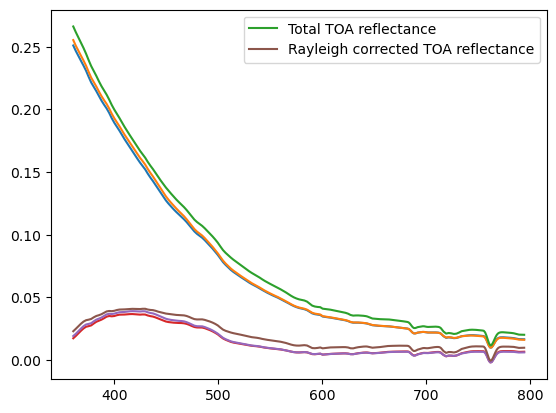

In [30]:
plt.plot(wavelengths,total_ref[150,300,:])
plt.plot(wavelengths,total_ref[200,300,:])
plt.plot(wavelengths,total_ref[300,300,:],label='Total TOA reflectance')


plt.plot(wavelengths,(total_ref-ray_ref)[150,300,:])
plt.plot(wavelengths,(total_ref-ray_ref)[200,300,:])
plt.plot(wavelengths,(total_ref-ray_ref)[300,300,:],label='Rayleigh corrected TOA reflectance')
plt.legend()


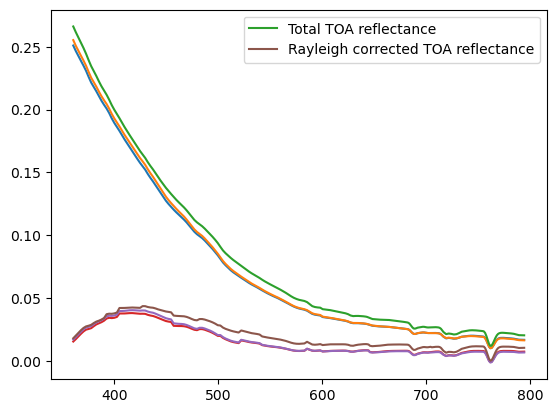

In [59]:
plt.plot(wavelengths,total_ref[150,300,:])
plt.plot(wavelengths,total_ref[200,300,:])
plt.plot(wavelengths,total_ref[300,300,:],label='Total TOA reflectance')


plt.plot(wavelengths,(total_ref-ray_ref)[150,300,:])
plt.plot(wavelengths,(total_ref-ray_ref)[200,300,:])
plt.plot(wavelengths,(total_ref-ray_ref)[300,300,:],label='Rayleigh corrected TOA reflectance')
plt.legend()


### Lets look at RGB plot and Rayleigh corrected RGB plot

Text(0.5, 1.0, 'RGB Image after Rayleigh correction')

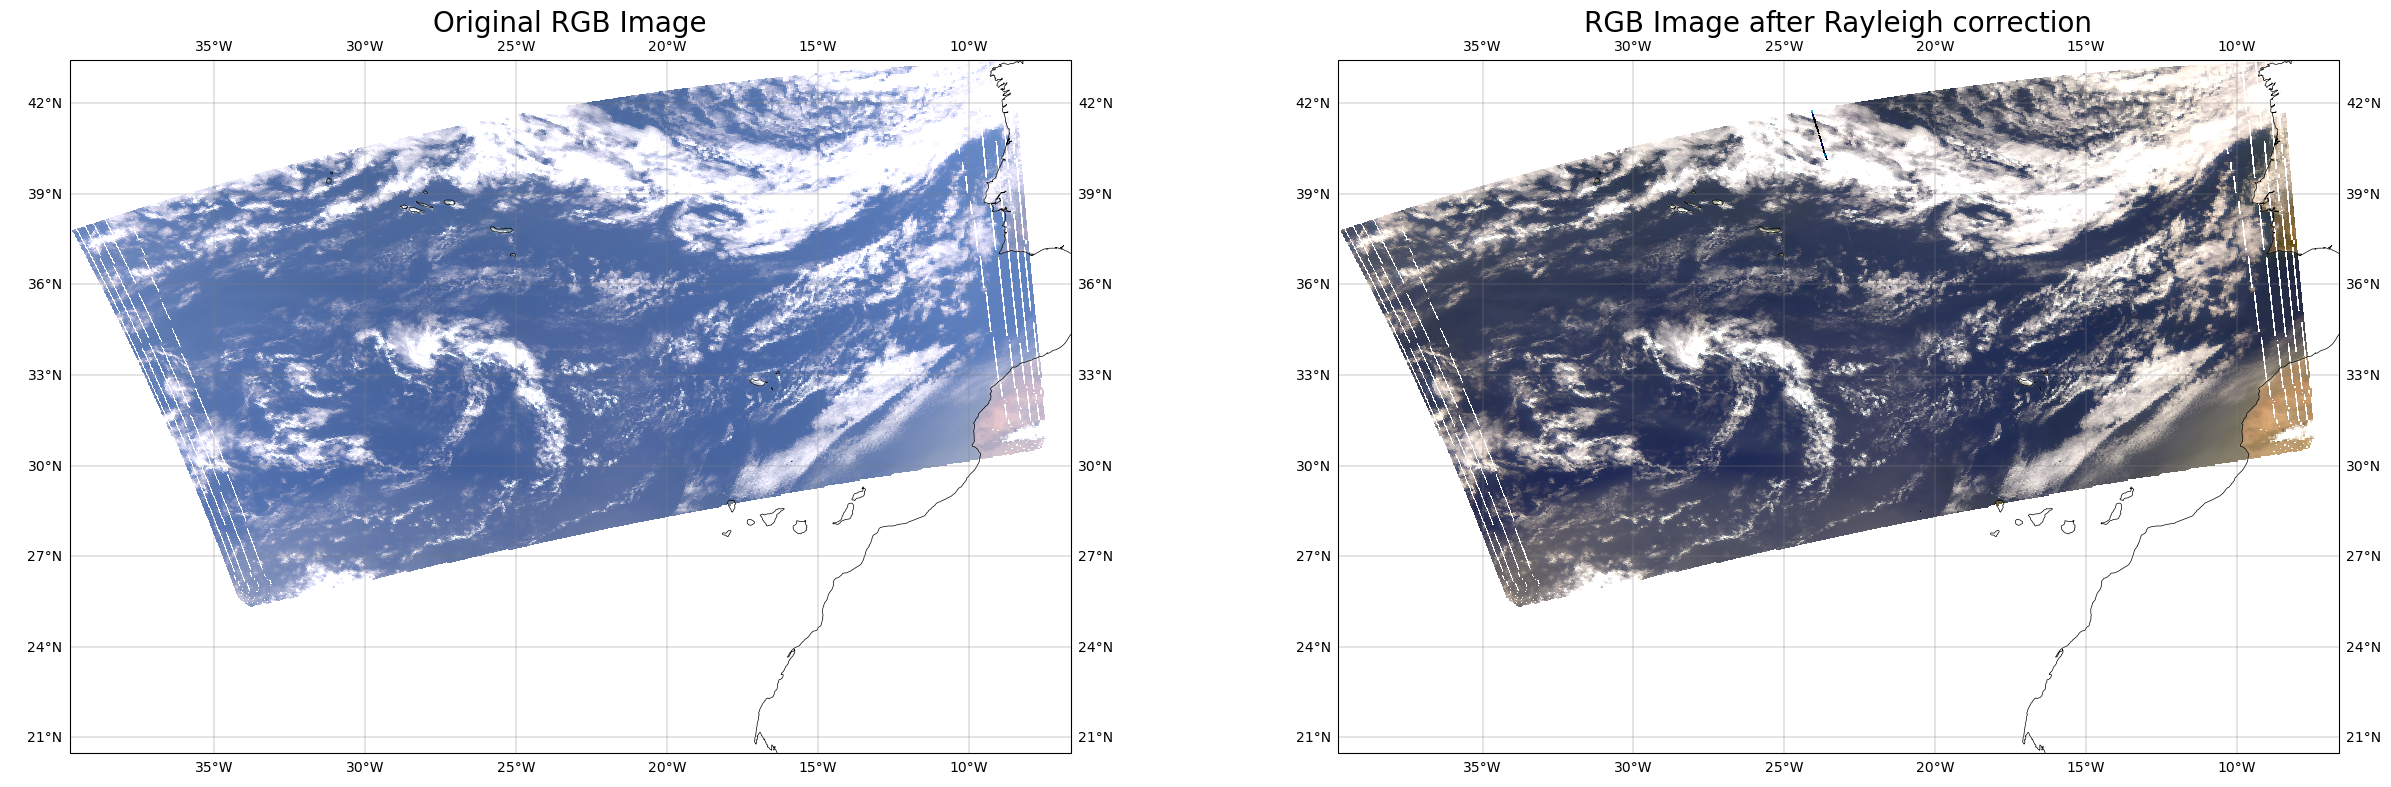

In [60]:
fig,ax=plt.subplots(1,2,figsize=[30,9],subplot_kw={'projection': ccrs.PlateCarree()})
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)


rgb_image(ax[0],ref,wavelengths)
rgb_image(ax[1],ref-ray_ref,wavelengths)
ax[0].set_title('Original RGB Image',fontsize=20)
ax[1].set_title('RGB Image after Rayleigh correction',fontsize=20)
#plt.savefig('corrected_rgb_rayleigh.pdf')
